**Speech Detection**



Dataset Used:-Speech Commands Datasets from kaggle





procedure followed for this assisment as follows.


*   Loded .wav samples
*   preprocessed data
*   Created CNN using Conv1D and Dense layers
*   Applied Hyperparameter tunning using keras Randomsearch
*   Trained model and tested
*   Got accuracy of 93% on test data


This model recognise words like Happy, yes,right,wow, bird, zero







In [31]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [32]:

import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing

 1.Load dataset ith sampling rate of 16000

In [3]:
audioFolderPath = '/content/drive/MyDrive/speech/train/train/audio/'
samples, sample_rate = librosa.load(audioFolderPath+'wow/0a0b46ae_nohash_0.wav', sr = 16000)

In [4]:
labels=os.listdir(audioFolderPath)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(audioFolderPath + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    

Analyse data

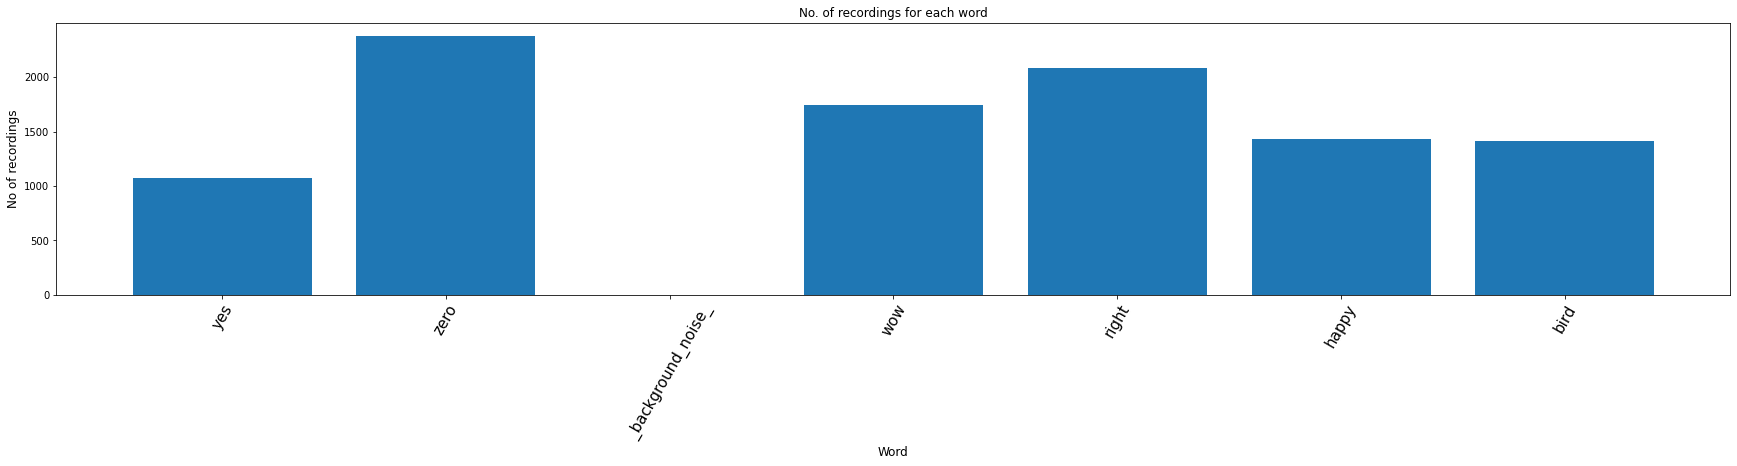

In [5]:
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Word', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each word')
plt.show()

In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13743103467061615126, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11694801682068911290
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

Resample data to sample rate of 8000

In [8]:
allSamples=[]
allLabels=[]

for label in labels:
  audioFullPath=os.path.join(audioFolderPath,label)
  wavFiles=[files for files in os.listdir(audioFullPath) if files.endswith('.wav')]
  for singleFile in wavFiles:
    samples, sampleRate= librosa.load(audioFolderPath+'/'+label+'/'+singleFile,sr=16000)
    updatedSample= librosa.resample(samples,sample_rate,8000)
    if(len(updatedSample)==8000):
      allSamples.append(updatedSample)
      allLabels.append(label)



Now convert utput labels to integers

In [9]:
from sklearn.preprocessing import LabelEncoder
lblEncoded = LabelEncoder()
y=lblEncoded.fit_transform(allLabels)


In [ ]:
Conv1D reqirs 3D array so convert samples from 2D to 3D

In [11]:
allWordsamples = np.array(allSamples).reshape(-1,8000,1)
print(allWordsamples.shape)

(9109, 8000, 1)


Now data is redy to split as train and text, perform splitting operation

In [12]:
from sklearn.model_selection import train_test_split
x_Tarin, x_Test, y_Train, y_Test = train_test_split(np.array(allWordsamples),np.array(y),stratify=y,test_size = 0.2,random_state=44,shuffle=True)

Create Model with 5 layers

In [13]:
import keras #requirs for creating convolution model layers

In [14]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=96, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [13,12]),
        activation='relu',
        padding='valid',
        input_shape=(8000,1)
    ),
    keras.layers.MaxPooling1D(3),
    keras.layers.Dropout(0.3),


    keras.layers.Conv1D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [11,10]),
        activation='relu'
    ),
    keras.layers.MaxPooling1D(3),
    keras.layers.Dropout(0.3),

     keras.layers.Conv1D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [9,7]),
        activation='relu'
    ),
    keras.layers.MaxPooling1D(3),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=156, step=16),
        activation='relu'
    ),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(labels), activation='softmax')
  ])
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

Import keras-tuner for hyperparameter tuning of model layers

In [15]:
pip install keras-tuner

     |████████████████████████████████| 71kB 5.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=f6ad43118dcc79be7c869b191e86a263cfb8368f3a86f8e84f8dd3058880cdfa
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=7177e62ff72af70d29f7d5b8e8c2e14d7251e00f63b03c2b09db542f5a272c16
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


apply hyperparameter tunning by using RandomSearch




In [16]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


In [17]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=3,directory='output',project_name="Speech Recognition ")

tuner_search.search(x_Tarin,y_Train,epochs=3,validation_split=0.1)

Trial 3 Complete [00h 00m 12s]
val_accuracy: 0.23319615423679352

Best val_accuracy So Far: 0.8381344079971313
Total elapsed time: 00h 00m 48s
INFO:tensorflow:Oracle triggered exit


Get best model and train on train samples

In [18]:

model=tuner_search.get_best_models(num_models=1)[0]
model.fit(x_Tarin, y_Train, epochs=10, validation_split=0.1, initial_epoch=3)
model.save('/content/drive/MyDrive/speech/final_model.h5')

Epoch 4/10
205/205 [==============================] - 5s 20ms/step - loss: 0.5480 - accuracy: 0.8068 - val_loss: 0.3908 - val_accuracy: 0.8834
Epoch 5/10
205/205 [==============================] - 4s 19ms/step - loss: 0.3981 - accuracy: 0.8601 - val_loss: 0.3313 - val_accuracy: 0.8903
Epoch 6/10
205/205 [==============================] - 4s 19ms/step - loss: 0.3537 - accuracy: 0.8742 - val_loss: 0.3250 - val_accuracy: 0.9067
Epoch 7/10
205/205 [==============================] - 4s 19ms/step - loss: 0.3279 - accuracy: 0.8889 - val_loss: 0.3484 - val_accuracy: 0.8944
Epoch 8/10
205/205 [==============================] - 4s 19ms/step - loss: 0.2688 - accuracy: 0.9061 - val_loss: 0.2715 - val_accuracy: 0.9218
Epoch 9/10
205/205 [==============================] - 4s 19ms/step - loss: 0.2392 - accuracy: 0.9173 - val_loss: 0.2598 - val_accuracy: 0.9218
Epoch 10/10
205/205 [==============================] - 4s 19ms/step - loss: 0.2307 - accuracy: 0.9235 - val_loss: 0.2591 - val_accuracy: 0.928

Best model is savesd as final_model.h5

Predict test samples on this model

In [21]:
result = model.predict_classes(x_Test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [24]:
from sklearn.metrics import classification_report, accuracy_score  
print(accuracy_score(y_Test,result))

0.9324917672886938


#On test data model achived 93% of accuracy

Now i recorde my vice saying "Happy" and checked on model

In [30]:
from keras.models import load_model
lodedModel=load_model("/content/drive/MyDrive/speech/final_model.h5")

In [33]:
newSamplePath="/content/drive/MyDrive/speech/happy.wav"
samples, sample_rate = librosa.load(newSamplePath, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)

In [39]:
reshapedSample = np.array(samples).reshape(-1,8000,1)
predictedIndex = lodedModel.predict_classes(reshapedSample)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [41]:
def PrdictWord(index):
  if(index==0):
    print("yes")
  if(index==1):
    print("zero")
  if(index==2):
    print("_background_noise_")
  if(index==3):
    print("wow")
  if(index==4):
    print("right")
  if(index==5):
    print("happy")
  if(index==6):
    print("bird")

In [42]:
PrdictWord(predictedIndex)

happy
